## Proceso de Aprendizaje

![training](training.png)

1. Preparación de los datos

    - Análisis, limpieza, preprocesamiento

    - Dataset y DataLoader clases en PyTorch

2. Entrenamiento

    - Construcción del modelo

    - Definiciones

        - Definición del función de coste

        - Definición del optimizador

        - Definición de los hiperparametros para el entrenamiento

    - Construcción del bucle para el entrenamiento y validación

        - Función para el entrenamiento

        - Función para la validación
    
3. Evaluación del modelo

    - Curvas de aprendizaje

    - Precisión

    - Matriz de confusión

## Predicción de Cáncer de Mama

Conjunto de datos disponible aquí: https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic

Vamos a predecir si una muestra de una masa mamaria es maligna o benigna a partir de las características de los núcleos celulares.

![cancer](cancer.png)


Descripción del conjunto de datos:
- id: identificador de la persona
- diagnóstico (diagnosis): si la muestra es maligna (M) or benigna (B) - **variable a predecir**

10 caracteristicas de cada núcleo celular:
- radio (radius)
- textura (texture)
- perímetro (perimeter)
- área (area)
- suavidad (smoothness)
- compacidad (compactness)
- concavidad (concavity)
- puntos cóncavas (concave points)
- simetría (symmetry)
- dimensión fractal (fractal dimension)

Para cada muestra y cada característica se calcula el promedio (mean), desviación estandar (se), y valor más grande (worst) de los núcleos celulares en la muestra que genera 30 características en total.


### Cargar las librerías

Primero cargamos las librerías que vamos a necesitar

In [2]:

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

import time

## Preparación de los datos

1. Análisis de los datos

2. Limpieza de los datos

3. Preprocesamiento de los datos

### 1. Análisis de los datos

Esta fase sirve para entender mejor las características de los datos de que disponemos.

In [3]:
# Leer los datos
data = pd.read_csv('cancer_data.csv')
data.head(5)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [4]:
# Imprimer los tipos de datos
print(data.dtypes)

id                           int64
diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst     

Vemos que hay dos variables que no añaderán valor a la predicción: ``id`` y ``Unnamed: 32``. Eliminamos estas variables del conjunto de datos. 

In [5]:
# Eliminar variables no necesarias
data = data.drop(['id', 'Unnamed: 32'], axis=1)

#### Análisis sobre las variables

In [6]:
data.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


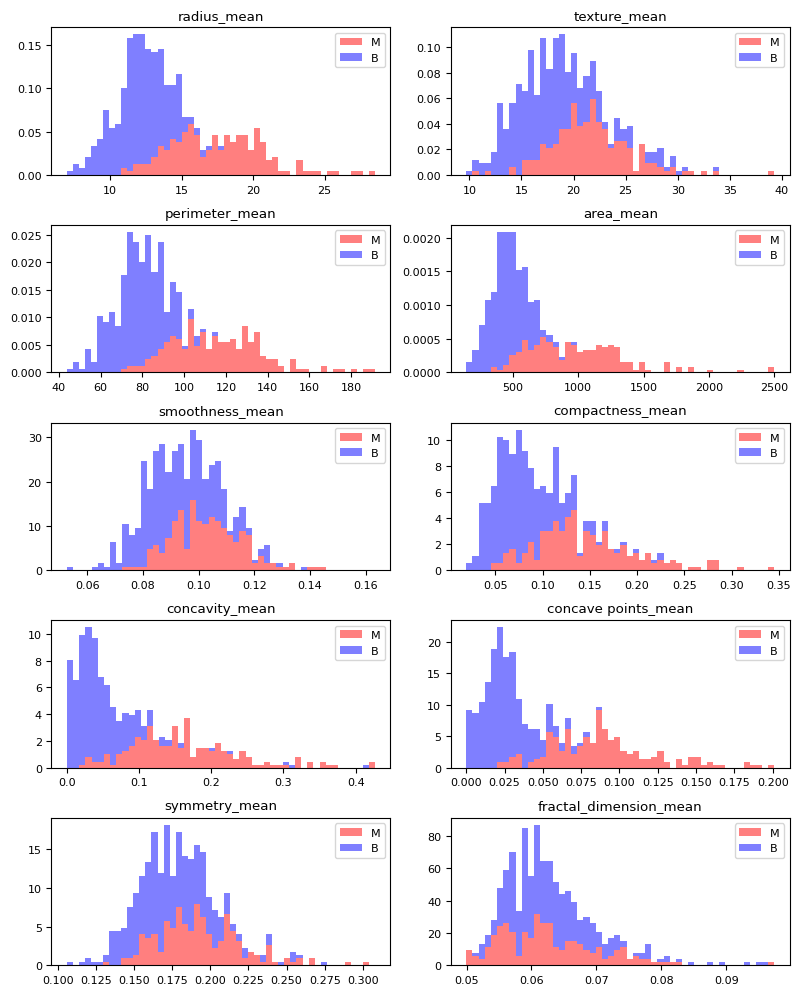

In [7]:
features = list(data.columns[1:11])
dfM=data[data['diagnosis'] =='M']
dfB=data[data['diagnosis'] =='B']
plt.rcParams.update({'font.size': 8})
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(8,10))
axes = axes.ravel()
for idx,ax in enumerate(axes):
    ax.figure
    binwidth= (max(data[features[idx]]) - min(data[features[idx]]))/50
    ax.hist([dfM[features[idx]],dfB[features[idx]]], bins=np.arange(min(data[features[idx]]), max(data[features[idx]]) + binwidth, binwidth) , alpha=0.5, stacked=True, density=True, label=['M','B'],color=['r','b'])
    ax.legend(loc='upper right')
    ax.set_title(features[idx])
plt.tight_layout()
plt.show()

#### Preguntas:

- ¿Qué ves en estos gráficos? 

- ¿Qué es el comportamiento de las variables entre los casos malignos y benignos?

- ¿Qué son otros tipos de análsis que se podría hacer sobre estos datos?

#### Análisis sobre la variable a predecir: diagnosis

Número de diagnósticos benignos:  357
Número de diagnósticos malignos:  212


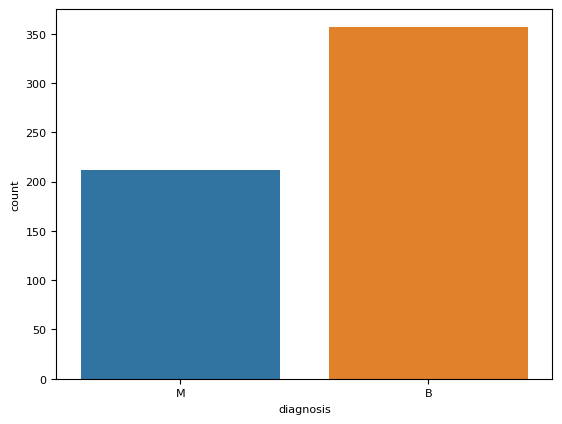

In [8]:
ax = sns.countplot(data, x="diagnosis", label="Número de diagnósticos") 
B, M = data.diagnosis.value_counts()
print('Número de diagnósticos benignos: ', B)
print('Número de diagnósticos malignos: ', M)

### 2. Limpieza de los datos

Comprobar valores ausentes en el conjunto de datos

In [9]:
pd.DataFrame({"variable": data.isna().sum().index, "número_valores_ausentes": data.isna().sum().values}).sort_values(by="número_valores_ausentes")

,variable,número_valores_ausentes
0,diagnosis,0
28,concave points_worst,0
27,concavity_worst,0
26,compactness_worst,0
25,smoothness_worst,0
24,area_worst,0
23,perimeter_worst,0
22,texture_worst,0
21,radius_worst,0
20,fractal_dimension_se,0


### 3. Preprocesamiento de los datos

1. Codificación de variables categóricas

2. Escalado de datos

3. Separar los datos en conjuntos de entrenamiento, validación y prueba



#### Codificación de variables categóricas

- La variable `diagnosis` es categórica (valores `M` y `B`) 

- Cambiamos estos valores a valores númericos para poder usarlos con una red neuronal

In [10]:
data['diagnosis'] = data['diagnosis'].map({'M': 1, 'B': 0})
data.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


#### Separación del conjunto de datos y Escalado de datos

- Separar datos en conjuntos de entrenamiento (65%), validación (20%) y prueba (15%)

- Escalado de datos:

    - realizar el ajuste solamente sobre los datos de entrenamiento y validación 

    - realizar la transformación sobre todos los datos (conjunto de prueba incluso)

    - simula mejor como funcionará el proceso en el mundo real

- Tipos de escalado

    - Normalización 

        - escalar los datos entre 0 y 1 o -1 y 1

        - usa los mínimos y máxmios de la variable 

    - Estandarización

        - escalara los datos para tener un valor medio de 0 y un desviación estándar 1
        
        - usa el valor medio y desviación estánder de la variable

Separamos primero el conjunto de datos en entrenamiento y prueba. Después de entrenar nuestro modelo, si queremos usarlo en el mundo real, vamos a usarlo sobre datos que hoy no tenemos acceso. 

Dado esto, hacemos el ajuste de la función de estandarización solamente sobre el conjunto de datos de entrenamiento. Luego hacemos la transformación sobre los conjuntos de entrenamiento y prueba. Hacemos esto para simular la situación en el mundo real lo más posible.

In [11]:
# Separamos la variable a predecir del resto de variables 
y = data['diagnosis'].copy()
x = data.drop('diagnosis', axis=1)
print(x.shape)
print(y.shape)

(569, 30)
(569,)


In [12]:
# Separamos el conjunto de datos en entrenamiento y prueba
# Usamos 15% de los datos para el conjunto de test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=True)

print('x_train:', x_train.shape)
print('y_train:', y_train.shape)
print('x_test:', x_test.shape)
print('y_test:', y_test.shape)

x_train: (483, 30)
y_train: (483,)
x_test: (86, 30)
y_test: (86,)


In [13]:
# Escalamos los datos usando StandarScaler
sc = StandardScaler()

# Realizamos el ajuste y transform sobre los datos de entrenamiento, pero solamente transformaamos los datos de prueba
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [14]:
# Separamos el conjunto de entrenamiento en conjuntos de entrenamiento y validación
# Usamos 20% de estos datos para la validación
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, shuffle=True)

print('x_train:', x_train.shape)
print('y_train:', y_train.shape)
print('x_val:', x_val.shape)
print('y_val:', y_val.shape)

x_train: (386, 30)
y_train: (386,)
x_val: (97, 30)
y_val: (97,)


In [15]:
# Utilizando estandarización los datos tienen un valor medio de 0 y desviación estandar 1
print("Valor medio entrenamiento: ", x_train[:,1].mean())
print("Valor desviación estandar entrenamiento: ", x_train[:,1].std())

print("Valor medio prueba: ", x_test[:,1].mean())
print("Valor desviación estandar prueba: ", x_test[:,1].std())

Valor medio entrenamiento:  -0.021101868154947617
Valor desviación estandar entrenamiento:  1.0106789891244095
Valor medio prueba:  -0.002430315267392902
Valor desviación estandar prueba:  1.0227314907962326


In [16]:
y

0      1
1      1
2      1
3      1
4      1
      ..
564    1
565    1
566    1
567    1
568    0
Name: diagnosis, Length: 569, dtype: int64

## PyTorch: Dataset y DataLoader

PyTorch tiene dos funciones para el procesamiento de los ejemplos de datos: 
- `torch.utils.data.Dataset`: almacena los datos y las etiquetas de ellos
- `torch.utils.data.DataLoader`: pasa los datos en lotes al modelo

#### Dataset

La clase `Dataset` tiene 3 funciones que hay que definir:

- `__init__`:
    - Especificar dónde está los datos y etiquetas 
    - Initializar cualquier transformación que queremos hacer sobre los datos


- `__len__`: 
    - Devuelva el número de ejemplos de datos que está en el conjunto de datos
    - Especifica el límite superior para los índices de los datos
    - En cada llamada al Dataset, se especifica un ejemplo de datos por su índice


- `__getitem__`: 
    - Carga y devuelve el ejemplo de datos que tiene el índice `idx`
    - Se puede aplicar las transformaciones que has especificado en la función `__init__`


Primero creamos la clase para el Dataset y luego creamos los Datasets para los conjuntos de datos.

In [17]:
# Dataset and DataLoader: define the function for the dataset
class BreastCancerDataset(Dataset):
    def __init__(self, x, y):
        # Initialización
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(np.array(y).astype(np.float32), dtype=torch.float32)
    
    def __len__(self):
        # Especifiar el número total de ejemplos
        return self.x.shape[0]
    
    def __getitem__(self, idx):
        # Genera un ejemplo de datos
        return self.x[idx], self.y[idx]

In [18]:
# Definimos los datasets para el entrenamiento, validación y prueba
train_dataset = BreastCancerDataset(x_train, y_train)
val_dataset = BreastCancerDataset(x_val, y_val)
test_dataset = BreastCancerDataset(x_test, y_test)

ValueError: could not determine the shape of object type 'Series'

In [ ]:
# Ejemplo de datos con índice 5
train_dataset.x[11]

In [ ]:
train_dataset.y[11]

#### DataLoader

- Divide los conjuntos de datos en "batches"

- Importante porque los conjuntos de datos de deep learning pueden ser muy grandes

- Asegura que no consume demasiado memoria

**Proceso**

- Usa la función `__getitem__` del Dataset para mandar batches de datos al modelo

- Se puede iterar a tráves de los datos 

- Hiperparámetros a especificar:

    - `batch_size`: número de ejemplos de datos en cada batch

    - `shuffle`: seleccionar los ejemplos para cada batch aleatoriamente (True) o seleccionar los ejemplos en orden de los datos (False)
    
    - `num_workers`: especificar más de 0 (el número de workers) si queremos usar multiprocesamiento

Para el entrenamiento es mejor usar `shuffle = True` para que el modelo no ve los datos en el mismo orden cada vez y los batches entre las épocas no son siempre lo mismo. Para validación y prueba se puede tener `shuffle = False`

In [ ]:
# Especificamos el tamaño del batch
batch_size = 64

# Definimos los dataloaders para el entrenamiento, validación y prueba
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [ ]:
# Vemos un batch de datos (un consiste en 64 ejemplos de datos)
for i_batch, (x_train, y_train) in enumerate(train_dataloader):
    print("número de batch :", i_batch)
    print("x_train en i_batch : ", x_train.size())
    print("y_train en i_batch :", y_train.size())
    break


### Definir el modelo

- Tamaño de la entrada: 30 (tenemos 30 variables)

- Capas: torch.nn.Linear - aplicar linear transformación a los datos y = Ax + b

    - Capa 1: 16 neuronas 

    - Capa 2:32 neuronas 

    - Capa 3: 1 neurona 

- Función de activación ReLU para capas 1 y 2

- Función de activación Sigmoid para capa 3

**Preguntas**

- ¿Por qué tiene la capa 3 solamente una neurona (por qué no ponemos 8 neuronas, por ejemplo)?

- ¿Por qué es la función de activación sigmoid para capa 3? (¿por qué no usamos ReLU como en capas 1 y 2?)

In [ ]:
# Define the model
class BreastCancerClassifier(nn.Module):

    #Initializar las capas
    def __init__(self, input_shape):
        super(BreastCancerClassifier, self).__init__()
        self.fc1 = nn.Linear(input_shape, 16) 
        self.fc2 = nn.Linear(16, 32) # 16, 32
        self.fc3 = nn.Linear(32, 1) # 32, 1

    # Implementar estas operaciones en los datos de entrada
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))  # x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))  # x = torch.sigmoid(self.fc3(x))
        return x

In [ ]:
# Especificar que queremos usar una GPU si está disponible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

In [ ]:
# Initializar el modelo
model = BreastCancerClassifier(input_shape=x.shape[1]).to(device)
print(model)

In [ ]:
for i_batch, (x_train, y_train) in enumerate(train_dataloader):
    print("número de batch :", i_batch)
    print("x_train en i_batch : ", x_train.size())
    print("y_train en i_batch :", y_train.size())
    break

# Vemos que son los outputs del modelo - probabilidades en este caso
outputs = model(x_train.to(device))
print(outputs)

### Función de coste

- Calcula los errores entre los valores predichos y los valores reales

- Devuelve el valor medio de los errores

- Muchas distintas funciones de coste

- Problema de regresión: Error medio cuadrado (`torch.nn.MSELoss`), Error absoluto medio (`torch.nn.L1Loss`), ...

- Problema de clasificación: Entropía cruzada binaria (`torch.nn.BCELoss`), Entropía cruzada categórica (`torch.nn.CrossEntropyLoss`), ...

**Pregunta**

- ¿Qué es la función de coste que deberíamos usar para nuestro problema de clasificación (2 clases)?

In [ ]:
# Usamos entropía cruzada binaria ya que es un problema de clasificación binaria
loss_fn = nn.BCELoss() 

### Optimizador

- La red neuronal lo usa para aprender los pesos y sesgos que minimiza la función de coste

- Se basa en descenso de gradiente

![gradient_descent](gradient_descent.png)

![gradient_descent_updates](gradient_descent_updates.png)

#### Optimizadores en PyTorch

Hay varios tipos de optimizadores en PyTorch:

- Descenso de gradiente estocástico (`torch.optim.SGD`)

- Adam (`torch.optim.Adam`)

- RMSProp (`torch.optim.RMSprop`)


**Usamos descenso de gradiente estocástico**

- Modificación de descenso de gradiente

- Usa solamente un subconjunto pequeño de los ejemplos de datos para calcular la gradiente (en vez de todos los ejemplos)

- Reduce el tiempo de cálculo

**Parametros**

- `params`: `model.parameters()` - parametros para optimizar

- `lr`: tasa de aprendizaje - calcula el tamaño del paso en cada iteración (qué rápido aprende)

In [ ]:
# Especifiar el optimizador y la tasa de aprendizaje
learning_rate = 0.01

optimizer = torch.optim.SGD(params=model.parameters(), lr=learning_rate)

### Definir una función para el entrenamiento durante una época

![training](training.png)

#### Pasos en el entrenamineto 

1. Generar un batch de datos desde del DataLoader (usa `__getitem__` de la clase Dataset)

2. Mover los datos a la GPU (si la estamos usando)

3. Pon a cero los gradientes para cada batch (no mezclar información del los gradientes del batch anterior)

4. Realizar la predicción (calcular las probabilidades)

5. Calcular el coste

6. Calcular los gradientes de la función de coste (backpropagation)

7. Ajustar los parametros (pesos y sesgos)

8. Guardar metricas de coste y precisión

In [ ]:
# Función para el entrenamiento de una época
def train(model, device, train_dataloader, optimizer, loss_fn):
    
    # Pon modelo en modo para entrenar
    model.train()
    
    # Especificar variables para las metricas
    epoch_loss = 0
    elements = 0
    correct_train = 0

    for i_batch, (x_train, y_train) in enumerate(train_dataloader):

        # Mover los datos al GPU (si estamos usandolo)
        x_train, y_train = x_train.to(device), y_train.to(device)
        
        # Pon a cero los gradientes para cada batch 
        # No mezclar información de los gradientes del batch anterior con este batch
        optimizer.zero_grad()

        # Calcular la salida del modelo
        predicciones = model(x_train)

        # Calcular las perdidas y el coste
        batch_loss = loss_fn(predicciones, y_train.reshape(-1,1))

        # Calcular los gradientes 
        batch_loss.backward()
        
        #Ajustar los parametros (pesos y sesgos)
        optimizer.step()

        # Calcular cuantos han sido predicho correctamente
        correct_batch = (y_train.reshape(-1,1) == predicciones.round()).sum()

        # Guardar las metricas
        epoch_loss += batch_loss.item()
        correct_train += correct_batch.detach().cpu().numpy() # Mover los datos al CPU
        elements += len(y_train)
    
    # Calcular la metrica para la época entera
    loss_train = epoch_loss / i_batch
    acc_train = correct_train / elements
    
    return loss_train, acc_train

### Definir una función para la validación durante una época

#### Pasos en la validación

1. Generar un batch de datos desde del DataLoader (usa `__getitem__` de la clase Dataset)

2. Mover los datos a la GPU (si la estamos usando)

3. Calcular las probabilidades

4. Calcular el coste

5. Guardar metricas de coste y precisión

In [ ]:
def evaluation(model, device, val_dataloader, loss_fn):
    # Pon modelo en modo para evaluar
    model.eval()

    # Especificar variables para las metricas
    epoch_loss = 0
    elements = 0
    correct_val = 0

    # No queremos calcular los gradientes
    with torch.no_grad(): 

         for i_batch, (x_val, y_val) in enumerate(val_dataloader):
            
            # Mover los datos al GPU (si estamos usandolo)
            x_val, y_val = x_val.to(device), y_val.to(device)

            # Calcular la salida del modelo
            predicciones = model(x_val)

            # Calcular las perdidas y el coste
            batch_loss = loss_fn(predicciones, y_val.reshape(-1,1))

            # Calcular cuantos han sido predicho correctamente
            correct_batch = (y_val.reshape(-1,1) == predicciones.round()).sum()

            # Guardar las metricas
            epoch_loss += batch_loss.item()
            correct_val += correct_batch.detach().cpu().numpy() # Mover los datos al CPU
            elements += len(y_val)
    
    # Calcular la metrica para la época entera
    loss_val = epoch_loss / i_batch
    acc_val = correct_val / elements
    
    return loss_val, acc_val

### Definir el bucle para el entrenamiento y validación

Bucle para ejeuctar el entrenamiento y validación para cada época

In [ ]:
def training_evaluation_loop(epochs, model, device, train_loader, val_loader, optimizer, loss_fn):
    # Iniciar temporizador para realize un seguimiento del tiempo de entrenamiento
    start = time.time()
    # Crear listas para las metricas
    loss_values_train = []
    acc_values_train = []
    loss_values_val = []
    acc_values_val = []

    for epoch in range(epochs):

        # Ejecutar función de entrenamiento y guardar las metricas
        loss_train, acc_train = train(model, device, train_loader, optimizer, loss_fn)
        loss_values_train.append(loss_train)
        acc_values_train.append(acc_train)

        # Ejecutar función de validación y guardar las metricas
        loss_val, acc_val = evaluation(model, device, val_loader, loss_fn)
        loss_values_val.append(loss_val)
        acc_values_val.append(acc_val)

         # Imprimir cada 10 epocas
        if epoch % 10 == 0:
            print(f'Epoch: {epoch:4.0f} | Train Loss: {loss_train:.5f}, Train Accuracy: {acc_train:.5f} | Validation Loss: {loss_val:.5f}, Val Accuracy: {acc_val:.5f}')
            
    end = time.time()
    total_time = end - start
   
    print(f'Tiempo total de entrenar: {total_time}')

    return loss_values_train, acc_values_train, loss_values_val, acc_values_val

**Ejecutar el bucle**

`epochs`: número de veces que el modelo ve el conjunto de datos de entrenamiento completo

In [ ]:
epochs = 100

loss_values_train, acc_values_train, loss_values_val, acc_values_val = training_evaluation_loop(epochs, model, device,
                                                                            train_dataloader, val_dataloader, optimizer, loss_fn)

### Evaluación 

Curvas de aprendizaje tráves de las épocas

- Pèrdidas

- Precisión

In [ ]:
plt.plot(list(range(epochs)), loss_values_train, label='Training Loss')
plt.plot(list(range(epochs)), loss_values_val, label='Validation Loss')
plt.title('Training & Validation Loss Curves')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

**Pregunta**

- ¿Qué podemos decir sobre las pérdidas (coste)?

In [ ]:
plt.plot(list(range(epochs)), acc_values_train, label='Training Accuracy')
plt.plot(list(range(epochs)), acc_values_val, label='Validation Accuracy')
plt.title('Training & Validation Accuray Curves')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

**Pregunta**

- ¿Qué podemos decir sobre la precisión?

### Probar el conjunto de prueba en el modelo

Evaluar el rendimiento del modelo con datos que no ha visto previamente.

- Mètrica de precisión

- Matriz de confusión 

In [ ]:
# Realizamos predicciones con el modelo entrenado
def predictions(model, test_dataloader):
    predictions = []
    true_labels = []

    correct_test = 0
    elements = 0
    model.eval()
    with torch.no_grad():
        for x_test, y_test in test_dataloader:
            x_test, y_test = x_test.to(device), y_test.to(device)
            outputs = model(x_test)
            predictions.append(outputs.round().detach().cpu().numpy())
            true_labels.append(y_test.detach().cpu().numpy())
            correct_batch = (y_test.reshape(-1,1) == outputs.round()).sum()
            correct_test += correct_batch.detach().cpu().numpy()
            elements += len(y_test) 

    predictions = np.vstack(predictions)
    true_labels = np.hstack(true_labels)
    print(f'El conjunto de prueba tiene un precisión de: {correct_test/elements*100}%') # test_loader

    return predictions, true_labels

In [ ]:
predictions, true_labels = predictions(model, test_dataloader)

In [ ]:
# Plot the confusion matrix
cm = confusion_matrix(true_labels, predictions)

df_cm = pd.DataFrame(cm, index = ["benigna", "maligna"], columns = ["benigna", "maligna"])
plt.figure(figsize = (7,7))
sns.heatmap(df_cm, annot=True, cmap=plt.cm.Blues, fmt='g')
plt.xlabel("Predicted Class", fontsize = 20)
plt.ylabel("True Class", fontsize = 20)
plt.show()

### Resumen

- Preprocesamiento de los datos para una red neuronal

- Datasets y DataLoaders en PyTorch

- Proceso para entrenar el modelo
    - Definición del modelo
    - Función del coste
    - Optimizador
    - Bucle para entrenar sobre varios épocas

- Evaluación de un modelo
    - Curvas de aprendizaje (coste y precisión)
    - Evaluación con el conjunto de prueba
    - Evaluación con una matriz de confusión